In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
## Implement a fully connected neural network consisting of 3*(Lin, ReLU) layer. Each size of 50 neurons. 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(28*28, 50)
        self.fc1 = nn.Linear(50, 50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view((-1, 28*28))  # Flatten input 
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Net())
model = model.to(device)
model.train()

Sequential(
  (0): Net(
    (fc0): Linear(in_features=784, out_features=50, bias=True)
    (fc1): Linear(in_features=50, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=10, bias=True)
  )
)

### Problem 2(a) 

In [7]:
### Step 1. Implement Regular Training on Model.

In [8]:
learning_rate = 0.0001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)
ce_loss = torch.nn.CrossEntropyLoss()
for epoch in range(1, 100):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)             
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        batch_loss = ce_loss(out, y_batch)
        batch_loss.backward()
        opt.step()

In [10]:
model.eval()
tot_test, tot_acc = 0.0, 0.0
for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    out = model(x_batch)
    pred = torch.max(out, dim=1)[1]
    acc = pred.eq(y_batch).sum().item()
    tot_acc += acc
    tot_test += x_batch.size()[0]
    
print(f"Accuracy: {tot_acc/tot_test}")

Accuracy: 0.97


In [11]:
### Step 2. Implement Interval Analysis on Trained Model.

In [12]:
# Define bound calculation
def affine_bounds(z_kMinus_l, z_kMinus_u, W, b):
    # hk(zk-1) = Wzk-1+b
    mu_kMinus = (z_kMinus_u + z_kMinus_l)/2
    r_kMinus = (z_kMinus_u - z_kMinus_l)/2
    mu_k = torch.matmul(mu_kMinus, W.T) + b
    r_k = torch.matmul(r_kMinus,(torch.abs(W)).T)
    zk_l = mu_k - r_k
    zk_u = mu_k + r_k
    return zk_l, zk_u

def relu_bounds(z_kMinus_l, z_kMinus_u):
    # hk(zk-1) = relu(zk-1)
    relu = torch.nn.ReLU()
    zk_l=relu(z_kMinus_l)
    zk_u=relu(z_kMinus_u)
    return zk_l, zk_u
    
# Bound propagation
def bound_prop(x_input, eps):
    # Initial bounds defined by Linf ball with eps (z0)
    x0 = x_input.view((-1, 28*28))
    z0_l = x0 - eps
    z0_u = x0 + eps
    # Propagate through first Linear Layer (z1) and Relu layer (z2)
    z1_l, z1_u = affine_bounds(z0_l, z0_u, model[0].fc0.weight, model[0].fc0.bias)
    z2_l, z2_u = relu_bounds(z1_l, z1_u)

    # Propagate through first Linear Layer (z3) and Relu layer (z4)
    z3_l, z3_u = affine_bounds(z2_l, z2_u, model[0].fc1.weight, model[0].fc1.bias)
    z4_l, z4_u = relu_bounds(z3_l, z3_u)

    # Propagate through Third Linear Layer (z1) and Relu layer (z5)
    z5_l, z5_u = affine_bounds(z4_l, z4_u, model[0].fc2.weight, model[0].fc2.bias)
    z6_l, z6_u = relu_bounds(z5_l, z5_u)

    # Propagate through Last Linear Layer to Logits bound (zK)
    zK_l, zK_u = affine_bounds(z6_l, z6_u, model[0].fc3.weight, model[0].fc3.bias)

    return zK_l, zK_u

def calc_zK_hat(zK_l,zK_u, ytrue):
    zK_hat = zK_u
    zK_hat[0,ytrue] = zK_l[0][ytrue]
    return zK_hat

In [13]:
# Calculate robustness
store_eps_2a = []
store_acc_2a = []
neighborhoods = np.linspace(0.01, 0.1, 10)  
for eps in neighborhoods:
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
        pred = []
        
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            pred.append(torch.argmax(zK_hat).item())
            
        pred = torch.as_tensor(pred)
        
        #print(pred)
            
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        
    print(f"Epsilon:{eps:.2f}, Accuracy: {tot_acc/tot_test}")
    store_eps_2a.append(eps)
    store_acc_2a.append(tot_acc/tot_test)

Epsilon:0.01, Accuracy: 0.0
Epsilon:0.02, Accuracy: 0.0
Epsilon:0.03, Accuracy: 0.0
Epsilon:0.04, Accuracy: 0.0
Epsilon:0.05, Accuracy: 0.0
Epsilon:0.06, Accuracy: 0.0
Epsilon:0.07, Accuracy: 0.0
Epsilon:0.08, Accuracy: 0.0
Epsilon:0.09, Accuracy: 0.0
Epsilon:0.10, Accuracy: 0.0


In [14]:
neighborhoods = np.linspace(0.001, 0.01, 10)  
for eps in neighborhoods:
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
        pred = []
        
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            pred.append(torch.argmax(zK_hat).item())
            
        pred = torch.as_tensor(pred)
        
        #print(pred)
            
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        
    print(f"Epsilon:{eps:.3f}, Accuracy: {tot_acc/tot_test}")
    store_eps_2a.append(eps)
    store_acc_2a.append(tot_acc/tot_test)

Epsilon:0.001, Accuracy: 0.0312
Epsilon:0.002, Accuracy: 0.0002
Epsilon:0.003, Accuracy: 0.0
Epsilon:0.004, Accuracy: 0.0
Epsilon:0.005, Accuracy: 0.0
Epsilon:0.006, Accuracy: 0.0
Epsilon:0.007, Accuracy: 0.0
Epsilon:0.008, Accuracy: 0.0
Epsilon:0.009, Accuracy: 0.0
Epsilon:0.010, Accuracy: 0.0


In [15]:
neighborhoods = np.linspace(0.0001, 0.001, 10)  
for eps in neighborhoods:
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
        pred = []
        
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            pred.append(torch.argmax(zK_hat).item())
            
        pred = torch.as_tensor(pred)
        
        #print(pred)
            
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        
    print(f"Epsilon:{eps:.4f}, Accuracy: {tot_acc/tot_test}")
    store_eps_2a.append(eps)
    store_acc_2a.append(tot_acc/tot_test)

Epsilon:0.0001, Accuracy: 0.9308
Epsilon:0.0002, Accuracy: 0.8262
Epsilon:0.0003, Accuracy: 0.6365
Epsilon:0.0004, Accuracy: 0.47
Epsilon:0.0005, Accuracy: 0.3259
Epsilon:0.0006, Accuracy: 0.2168
Epsilon:0.0007, Accuracy: 0.1428
Epsilon:0.0008, Accuracy: 0.0904
Epsilon:0.0009, Accuracy: 0.0536
Epsilon:0.0010, Accuracy: 0.0312


### Problem 2(b) 

In [14]:
### Step 1. Training Provably Robust Model

In [10]:
learning_rate = 0.0001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)
ce_loss = torch.nn.CrossEntropyLoss()
for epoch in range(1, 100):
    eps = (epoch - 1)/1000
    kappa = 1 - (epoch-1)/200
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)             
        model.train()
        opt.zero_grad()
        out = model(x_batch)

        # include loss from Lspec in addition to Lfit
        zK_hat_batch = []
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            zK_hat_batch.append(zK_hat)
        out_zKhat = torch.cat(zK_hat_batch)
        
        batch_loss = kappa*ce_loss(out, y_batch)+(1-kappa)*ce_loss(out_zKhat, y_batch)
        
        batch_loss.backward()
        opt.step()

In [ ]:
### Step 2. Evaluate Model Robustness

In [21]:
store_eps = []
store_acc = []
neighborhoods = np.linspace(0.01, 0.1, 10)  
for eps in neighborhoods:
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
        pred = []
        
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            pred.append(torch.argmax(zK_hat).item())
            
        pred = torch.as_tensor(pred)
        
        #print(pred)
            
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        
    print(f"Epsilon:{eps:.2f}, Accuracy: {tot_acc/tot_test}")
    store_eps.append(eps)
    store_acc.append(tot_acc/tot_test)

Epsilon:0.01, Accuracy: 0.9228
Epsilon:0.02, Accuracy: 0.9115
Epsilon:0.03, Accuracy: 0.8971
Epsilon:0.04, Accuracy: 0.8791
Epsilon:0.05, Accuracy: 0.8584
Epsilon:0.06, Accuracy: 0.8412
Epsilon:0.07, Accuracy: 0.8169
Epsilon:0.08, Accuracy: 0.7879
Epsilon:0.09, Accuracy: 0.7561
Epsilon:0.10, Accuracy: 0.7161


In [22]:
neighborhoods = np.linspace(0.001, 0.01, 10)  
for eps in neighborhoods:
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
        pred = []
        
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            pred.append(torch.argmax(zK_hat).item())
            
        pred = torch.as_tensor(pred)
        
        #print(pred)
            
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        
    print(f"Epsilon:{eps:.3f}, Accuracy: {tot_acc/tot_test}")
    store_eps.append(eps)
    store_acc.append(tot_acc/tot_test)

Epsilon:0.001, Accuracy: 0.9304
Epsilon:0.002, Accuracy: 0.9293
Epsilon:0.003, Accuracy: 0.9289
Epsilon:0.004, Accuracy: 0.9278
Epsilon:0.005, Accuracy: 0.9272
Epsilon:0.006, Accuracy: 0.9262
Epsilon:0.007, Accuracy: 0.9251
Epsilon:0.008, Accuracy: 0.9241
Epsilon:0.009, Accuracy: 0.9236
Epsilon:0.010, Accuracy: 0.9228


In [23]:
neighborhoods = np.linspace(0.0001, 0.001, 10) 
for eps in neighborhoods:
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
        pred = []
        
        for i in range(len(x_batch)):
            zK_l, zK_u = bound_prop(x_batch[i,0,:,:], eps)
            zK_hat = calc_zK_hat(zK_l,zK_u, y_batch[i].item())
            pred.append(torch.argmax(zK_hat).item())
            
        pred = torch.as_tensor(pred)
        
        #print(pred)
            
        acc = pred.eq(y_batch).sum().item()
        tot_acc += acc
        tot_test += x_batch.size()[0]
        
    print(f"Epsilon:{eps:.4f}, Accuracy: {tot_acc/tot_test}")
    store_eps.append(eps)
    store_acc.append(tot_acc/tot_test)

Epsilon:0.0001, Accuracy: 0.9314
Epsilon:0.0002, Accuracy: 0.9314
Epsilon:0.0003, Accuracy: 0.9314
Epsilon:0.0004, Accuracy: 0.9313
Epsilon:0.0005, Accuracy: 0.931
Epsilon:0.0006, Accuracy: 0.931
Epsilon:0.0007, Accuracy: 0.9308
Epsilon:0.0008, Accuracy: 0.9308
Epsilon:0.0009, Accuracy: 0.9307
Epsilon:0.0010, Accuracy: 0.9304


### Plotting

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
data_2b=pd.DataFrame([store_eps, store_acc]).transpose()
data_2b.columns=['eps', 'acc']
data_2b=data_2b.drop_duplicates().sort_values('eps')

In [41]:
data_2b.to_csv('data_2b.csv', index = False)

In [19]:
data_2a = pd.DataFrame([store_eps_2a, store_acc_2a]).transpose()
data_2a.columns=['eps', 'acc']
data_2a=data_2a.drop_duplicates().sort_values('eps')

In [21]:
data_2a.to_csv('data_2a.csv', index=False)

In [7]:
data_2b = pd.read_csv('data_2b.csv')

In [8]:
data_2a = pd.read_csv('data_2a.csv')

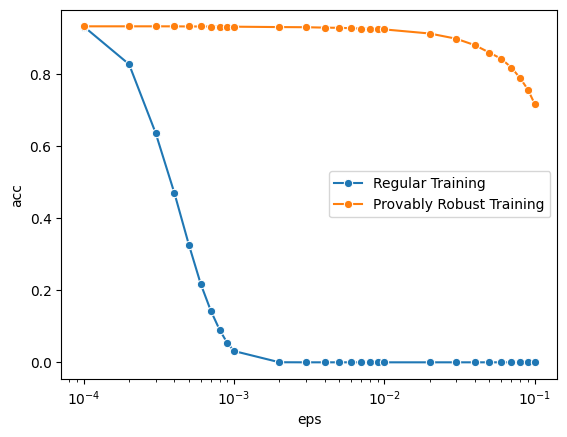

In [14]:
sns.lineplot(x='eps', y='acc', data=data_2a, label = 'Regular Training', marker = 'o')
sns.lineplot(x='eps', y='acc', data=data_2b, label = 'Provably Robust Training', marker = 'o')
plt.xscale('log')

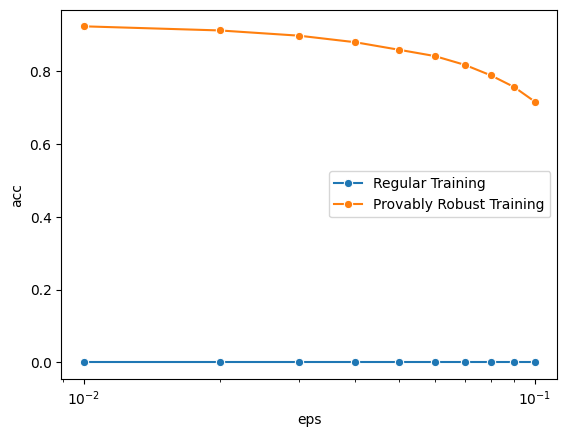

In [15]:
sns.lineplot(x='eps', y='acc', data=data_2a.iloc[-10:], label = 'Regular Training', marker = 'o')
sns.lineplot(x='eps', y='acc', data=data_2b.iloc[-10:], label = 'Provably Robust Training', marker = 'o')
plt.xscale('log')

In [18]:
data_2a

,eps,acc
0,0.0001,0.9308
1,0.0002,0.8262
2,0.0003,0.6365
3,0.0004,0.4700
4,0.0005,0.3259
5,0.0006,0.2168
6,0.0007,0.1428
7,0.0008,0.0904
8,0.0009,0.0536
9,0.0010,0.0312


In [19]:
data_2b

,eps,acc
0,0.0001,0.9314
1,0.0002,0.9314
2,0.0003,0.9314
3,0.0004,0.9313
4,0.0005,0.9310
5,0.0006,0.9310
6,0.0007,0.9308
7,0.0008,0.9308
8,0.0009,0.9307
9,0.0010,0.9304
